# Intermediate Notebook: Exploratory Data Analysis
*Deval Mehta*

## Key Insights
Here we conduct the exploration stage of the project independently before compiling all the necessary information into a final analysis notebook. Given the nature of the data, there is not much to be gleaned from summary statistics, the notable exception being that the Q27 has the most stops of any bus we've tracked. Incidentally, the Q27 also has the most buses running across it. We see relatively quickly that the data is complete and outliers are relatively few. We appear to have sampled a number of data points in the Bronx, but those are easily removed by either a spatial inner join or isolating any coordinates north of 40.8.

## Progress Report
Performing EDA on spatial data in particular has been interesting. Unlike most of the data we've considered throughout the course, there was not much I could really learn from summary statistics, except for what which bus route was the most well serviced. I decided the best way to explore the data was to:
- Map the static data out and check which neighborhoods have the highest and lowest stop density
- Perform a similar spatial analysis for buses found throughout the day in each neighborhood
- Perform a temporal analysis to see when each route was the busiest and which were the most underserviced.

Working with data in GeoPandas has been such a fruitful experience. I've learned how to produce higher quality maps and realized that geographical data can be extremely flexible, with the right tools. While there was definitely some steepness in the learning curve, GeoPandas is now a tool I can comfortably say I can work with, even without having done too much with it yet. Parsing in 23 real-time data frames has also been interesting (but I did that to myself). Realizing I could load them all in efficiently using a dictionary was an absolute gamechanger. No real roadblocks beyond that and trying to determine how to set a colormap when `.set_cmap()` didn't work.

In [64]:
# Imports
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from shapely.geometry import Point

## Static Data - Bus Stops in Eastern Queens

In [23]:
stops = pd.read_csv('../data/stops.csv')

stops.head()

,Route ID,Stop ID,Stop Name,Latitude,Longitude
0,MTA%20NYCT_Q1,MTA_500002,165 ST/HILLSIDE AV,40.709146,-73.797156
1,MTA%20NYCT_Q1,MTA_500004,HILLSIDE AV/171 ST,40.711440,-73.790887
2,MTA%20NYCT_Q1,MTA_500007,HILLSIDE AV/180 ST,40.712872,-73.782724
3,MTA%20NYCT_Q1,MTA_500008,HILLSIDE AV/182 PL,40.713574,-73.779850
4,MTA%20NYCT_Q1,MTA_500009,HILLSIDE AV/184 ST,40.714085,-73.777516


In [24]:
stops.columns = ['route_id', 'stop_id', 'stop_name', 'latitude', 'longitude']
stops.head()

,route_id,stop_id,stop_name,latitude,longitude
0,MTA%20NYCT_Q1,MTA_500002,165 ST/HILLSIDE AV,40.709146,-73.797156
1,MTA%20NYCT_Q1,MTA_500004,HILLSIDE AV/171 ST,40.711440,-73.790887
2,MTA%20NYCT_Q1,MTA_500007,HILLSIDE AV/180 ST,40.712872,-73.782724
3,MTA%20NYCT_Q1,MTA_500008,HILLSIDE AV/182 PL,40.713574,-73.779850
4,MTA%20NYCT_Q1,MTA_500009,HILLSIDE AV/184 ST,40.714085,-73.777516


In [25]:
# Save the list of routes separately to help read in the real-time data
routes = [' '.join(route.split('%20')) for route in stops['route_id'].unique()]
routes

['MTA NYCT_Q1',
 'MTA NYCT_Q2',
 'MTA NYCT_Q3',
 'MTA NYCT_Q4',
 'MTA NYCT_Q5',
 'MTA NYCT_Q12',
 'MTA NYCT_Q13',
 'MTA NYCT_Q20A',
 'MTA NYCT_Q20B',
 'MTA NYCT_Q27',
 'MTA NYCT_Q28',
 'MTA NYCT_Q30',
 'MTA NYCT_Q31',
 'MTA NYCT_Q36',
 'MTA NYCT_Q43',
 'MTA NYCT_Q44+',
 'MTA NYCT_Q46',
 'MTA NYCT_Q76',
 'MTA NYCT_Q77',
 'MTA NYCT_Q83',
 'MTA NYCT_Q84',
 'MTA NYCT_Q85',
 'MTA NYCT_Q88']

In [26]:
stops['route_id'] = ['_'.join(route.split('%20')) for route in stops['route_id']]
stops.head()

,route_id,stop_id,stop_name,latitude,longitude
0,MTA_NYCT_Q1,MTA_500002,165 ST/HILLSIDE AV,40.709146,-73.797156
1,MTA_NYCT_Q1,MTA_500004,HILLSIDE AV/171 ST,40.711440,-73.790887
2,MTA_NYCT_Q1,MTA_500007,HILLSIDE AV/180 ST,40.712872,-73.782724
3,MTA_NYCT_Q1,MTA_500008,HILLSIDE AV/182 PL,40.713574,-73.779850
4,MTA_NYCT_Q1,MTA_500009,HILLSIDE AV/184 ST,40.714085,-73.777516


In [27]:
stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2300 entries, 0 to 2299
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   route_id   2300 non-null   object 
 1   stop_id    2300 non-null   object 
 2   stop_name  2300 non-null   object 
 3   latitude   2300 non-null   float64
 4   longitude  2300 non-null   float64
dtypes: float64(2), object(3)
memory usage: 90.0+ KB


In [28]:
stops.describe(include = 'all')

,route_id,stop_id,stop_name,latitude,longitude
count,2300,2300,2300,2300.000000,2300.000000
unique,23,1653,1194,NaN,NaN
top,MTA_NYCT_Q27,MTA_500004,ARCHER AV/SUTPHIN BLVD,NaN,NaN
freq,153,7,12,NaN,NaN
mean,NaN,NaN,NaN,40.727568,-73.777085
std,NaN,NaN,NaN,0.032617,0.033510
min,NaN,NaN,NaN,40.644892,-73.878374
25%,NaN,NaN,NaN,40.704223,-73.799480
50%,NaN,NaN,NaN,40.725414,-73.777023
75%,NaN,NaN,NaN,40.753651,-73.751026


In [29]:
stops_gdf = gpd.GeoDataFrame(
    stops, geometry = gpd.points_from_xy(stops['longitude'], stops['latitude']), crs="EPSG:4326"
)

stops_gdf.head()

,route_id,stop_id,stop_name,latitude,longitude,geometry
0,MTA_NYCT_Q1,MTA_500002,165 ST/HILLSIDE AV,40.709146,-73.797156,POINT (-73.79716 40.70915)
1,MTA_NYCT_Q1,MTA_500004,HILLSIDE AV/171 ST,40.711440,-73.790887,POINT (-73.79089 40.71144)
2,MTA_NYCT_Q1,MTA_500007,HILLSIDE AV/180 ST,40.712872,-73.782724,POINT (-73.78272 40.71287)
3,MTA_NYCT_Q1,MTA_500008,HILLSIDE AV/182 PL,40.713574,-73.779850,POINT (-73.77985 40.71357)
4,MTA_NYCT_Q1,MTA_500009,HILLSIDE AV/184 ST,40.714085,-73.777516,POINT (-73.77752 40.71408)


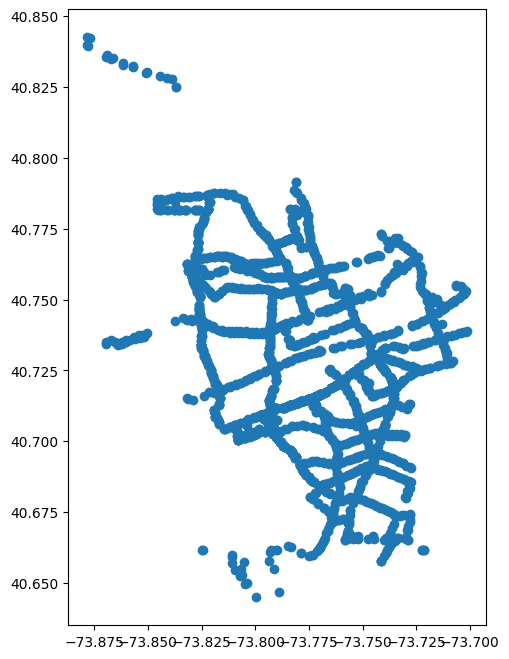

In [30]:
fig, ax = plt.subplots(figsize = (8,8))
stops_gdf.plot(ax = ax)
plt.savefig('../images/east_queens_bus_map.png', dpi = 300)

In [31]:
# Load NYC borough boundaries
nyc_boundaries = gpd.read_file('../data/borough_boundaries.geojson')

nyc_boundaries

,boro_code,boro_name,shape_area,shape_leng,geometry
0,5,Staten Island,1623618684.31,325910.306061,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
1,1,Manhattan,636646043.944,360037.634094,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
2,2,Bronx,1187174772.2,463180.578868,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
3,3,Brooklyn,1934142774.75,728143.833073,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ..."
4,4,Queens,3041416726.79,887896.284851,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."


In [32]:
nyc_boundaries.describe(include = 'all')

,boro_code,boro_name,shape_area,shape_leng,geometry
count,5,5,5,5,5
unique,5,5,5,5,5
top,5,Staten Island,1623618684.31,325910.306061,MULTIPOLYGON (((-74.05050806403247 40.56642203...
freq,1,1,1,1,1


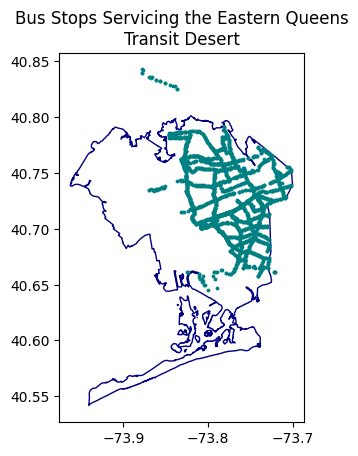

In [33]:
# Filter to Queens
queens_boundaries = nyc_boundaries[nyc_boundaries['boro_name'] == 'Queens']

# Plot stops on a map
base_layer = queens_boundaries.plot(color = 'white', edgecolor = 'navy')
stops_gdf.plot(ax = base_layer, color = 'teal', markersize = 3)
plt.title("Bus Stops Servicing the Eastern Queens\nTransit Desert")
plt.savefig('../images/east_queens_overlay.png', dpi = 300)
plt.show();

In [34]:
# Load NYC Neighborhoods
nyc_by_neighborhood = gpd.read_file('../data/nyc_by_neighborhood_2020.geojson')

nyc_by_neighborhood.head()

,shape_area,ntaname,cdtaname,shape_leng,boroname,ntatype,nta2020,borocode,countyfips,ntaabbrev,cdta2020,geometry
0,35321204.8204,Greenpoint,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.5653122,Brooklyn,0,BK0101,3,047,Grnpt,BK01,"MULTIPOLYGON (((-73.93213 40.72816, -73.93238 ..."
1,28854314.555,Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.0267744,Brooklyn,0,BK0102,3,047,Wllmsbrg,BK01,"MULTIPOLYGON (((-73.95814 40.7244, -73.95772 4..."
2,15208960.44,South Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18250.2804159,Brooklyn,0,BK0103,3,047,SWllmsbrg,BK01,"MULTIPOLYGON (((-73.95024 40.70547, -73.94984 ..."
3,52266209.4439,East Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.773814,Brooklyn,0,BK0104,3,047,EWllmsbrg,BK01,"MULTIPOLYGON (((-73.92406 40.71411, -73.92404 ..."
4,9982321.73877,Brooklyn Heights,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,14312.506134,Brooklyn,0,BK0201,3,047,BkHts,BK02,"MULTIPOLYGON (((-73.99103 40.69985, -73.99124 ..."


In [35]:
nyc_by_neighborhood.describe(include = 'all')

,shape_area,ntaname,cdtaname,shape_leng,boroname,ntatype,nta2020,borocode,countyfips,ntaabbrev,cdta2020,geometry
count,262,262,262,262,262,262,262,262,262,262,262,262
unique,262,262,71,262,5,6,262,5,5,262,71,262
top,23377916.5113,Great Kills Park,QN01 Astoria-Queensbridge (CD 1 Equivalent),41763.1645788,Queens,0,SI9593,4,081,GrtKlsPk,QN01,MULTIPOLYGON (((-73.96283963628261 40.69803866...
freq,1,1,9,1,82,197,1,82,82,1,9,1


In [36]:
# Filter to Queens
queens_neighborhoods = nyc_by_neighborhood[nyc_by_neighborhood['boroname'] == 'Queens']

# Perform a spatial join to assign stops to each neighborhood
stops_by_neighborhood = gpd.sjoin(stops_gdf, queens_neighborhoods, how = 'inner', predicate = 'within')

stops_by_neighborhood.head()

,route_id,stop_id,stop_name,latitude,longitude,geometry,index_right,shape_area,ntaname,cdtaname,shape_leng,boroname,ntatype,nta2020,borocode,countyfips,ntaabbrev,cdta2020
0,MTA_NYCT_Q1,MTA_500002,165 ST/HILLSIDE AV,40.709146,-73.797156,POINT (-73.79716 40.70915),215,46824594.0674,Jamaica,QN12 Jamaica-St. Albans-Hollis (CD 12 Approxim...,41771.9327189,Queens,0,QN1201,4,081,Jmca,QN12
1,MTA_NYCT_Q1,MTA_500004,HILLSIDE AV/171 ST,40.711440,-73.790887,POINT (-73.79089 40.71144),215,46824594.0674,Jamaica,QN12 Jamaica-St. Albans-Hollis (CD 12 Approxim...,41771.9327189,Queens,0,QN1201,4,081,Jmca,QN12
2,MTA_NYCT_Q1,MTA_500007,HILLSIDE AV/180 ST,40.712872,-73.782724,POINT (-73.78272 40.71287),215,46824594.0674,Jamaica,QN12 Jamaica-St. Albans-Hollis (CD 12 Approxim...,41771.9327189,Queens,0,QN1201,4,081,Jmca,QN12
3,MTA_NYCT_Q1,MTA_500008,HILLSIDE AV/182 PL,40.713574,-73.779850,POINT (-73.77985 40.71357),215,46824594.0674,Jamaica,QN12 Jamaica-St. Albans-Hollis (CD 12 Approxim...,41771.9327189,Queens,0,QN1201,4,081,Jmca,QN12
4,MTA_NYCT_Q1,MTA_500009,HILLSIDE AV/184 ST,40.714085,-73.777516,POINT (-73.77752 40.71408),215,46824594.0674,Jamaica,QN12 Jamaica-St. Albans-Hollis (CD 12 Approxim...,41771.9327189,Queens,0,QN1201,4,081,Jmca,QN12


In [37]:
# Group by Neighborhood and Count
stops_by_neighborhood['count'] = 1
stop_density = stops_by_neighborhood.groupby(by = 'ntaname').size().reset_index(name = "stop_count")

# Merge stop_density back into stops_by_neighborhood to plot
queens_neighborhoods = queens_neighborhoods.merge(stop_density, on = 'ntaname', how = 'left')

# Fill NaN values for neighborhoods with no stops|
queens_neighborhoods['stop_count'] = queens_neighborhoods['stop_count'].fillna(0)

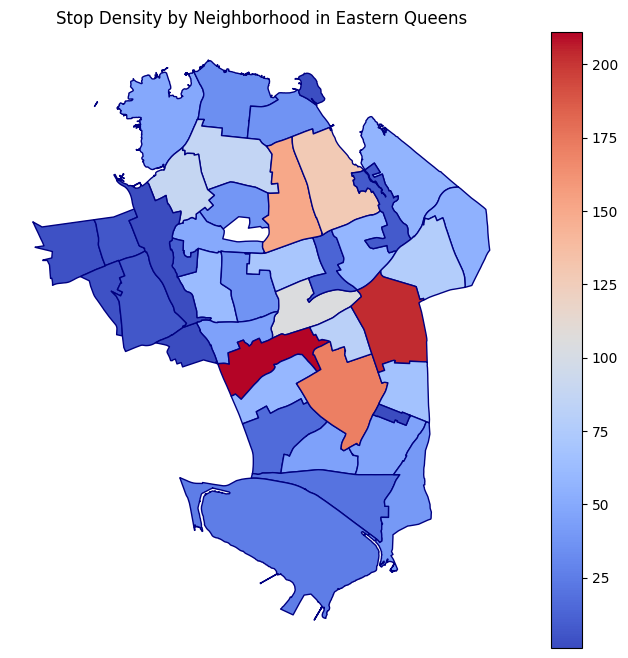

In [59]:
# Stop Density Heatmap
eastern_queens_neighborhoods.plot(
    column = 'stop_count',
    cmap = 'coolwarm',
    legend = 'True',
    figsize = (10, 8),
    edgecolor = 'navy'
)
plt.title('Stop Density by Neighborhood in Eastern Queens')
plt.axis('off')
plt.savefig('../images/eastern_queens_stop_density.png', dpi = 300)
plt.show();

In [39]:
eastern_queens_neighborhoods = queens_neighborhoods[queens_neighborhoods['stop_count'] > 0]

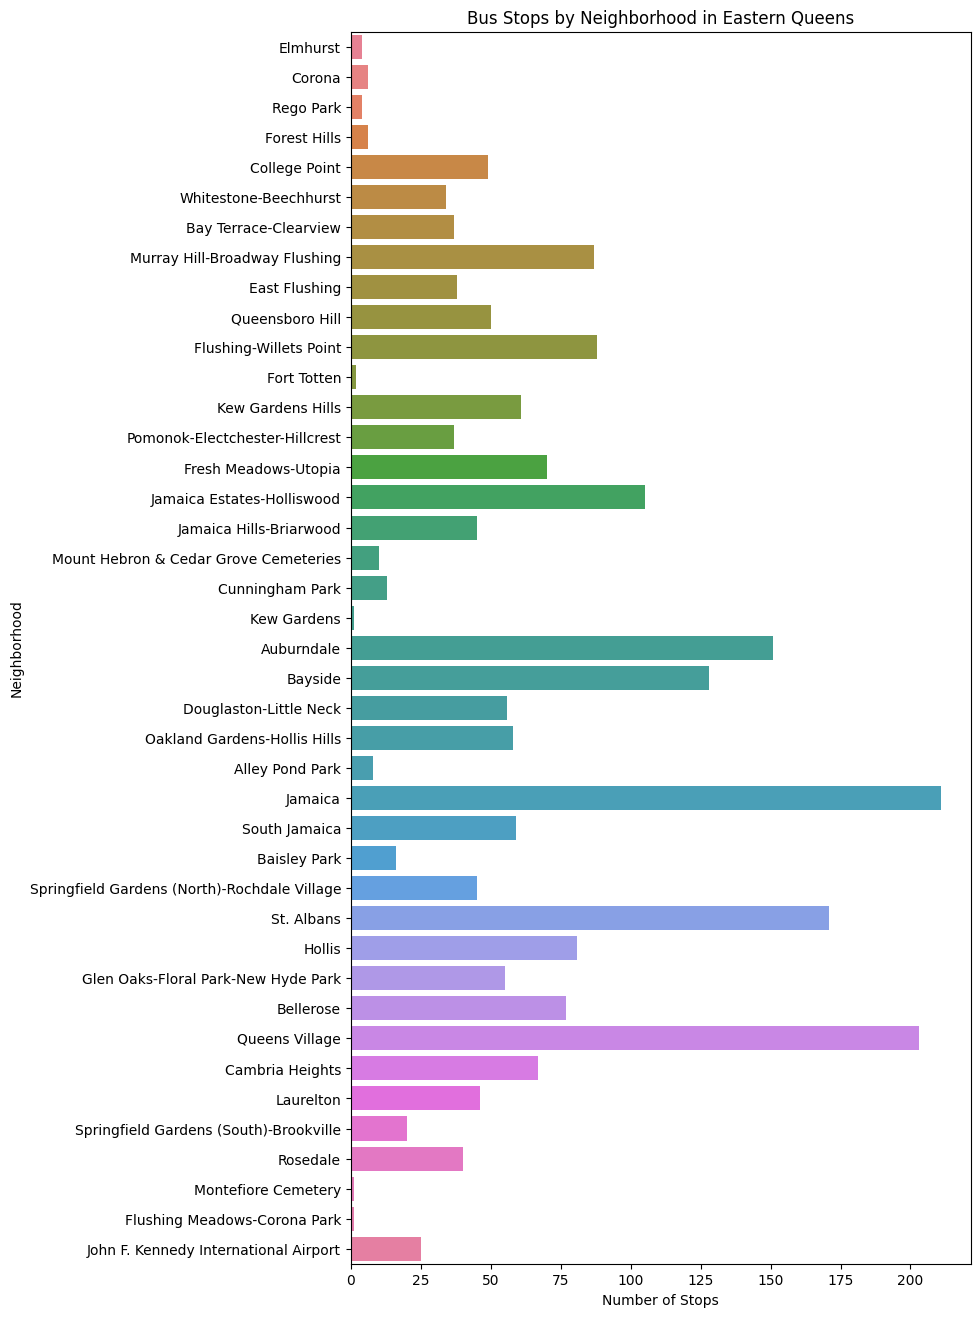

In [84]:
plt.figure(figsize = (8, 16))
sns.barplot(
    data = eastern_queens_neighborhoods,
    x = 'stop_count',
    y = 'ntaname',
    hue = 'ntaname'
)
plt.title('Bus Stops by Neighborhood in Eastern Queens')
plt.xlabel('Number of Stops')
plt.ylabel('Neighborhood')
plt.savefig('../images/eastern_queens_bus_stops_by_neighborhood.png', dpi = 300)
plt.show();

## Real-Time Data - Buses along 23 Routes

In [41]:
# Load in the data for each route
data_dir = '../data/'

# Initialize a dictionary to hold the real-time DataFrames
real_time_dfs = {}

# Loop through all files in the directory
for file in os.listdir(data_dir):
    if file.startswith('realtime_data_') and file.endswith('.csv'):
        route_id = file.split('_')[-1].replace('.csv', '')
        df = pd.read_csv(os.path.join(data_dir, file))
        real_time_dfs[route_id] = df

for route in real_time_dfs.keys():
    display(real_time_dfs[route].head())

,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
0,MTA NYCT_Q1,MTA NYCT_8517,40.707932,-73.795738,2025-01-11T07:24:03.194204
1,MTA NYCT_Q1,MTA NYCT_8498,40.718168,-73.735324,2025-01-11T07:24:03.194204
2,MTA NYCT_Q1,MTA NYCT_8304,40.712078,-73.786105,2025-01-11T07:24:03.194204
3,MTA NYCT_Q1,MTA NYCT_8304,40.717871,-73.735625,2025-01-11T07:54:01.281658
4,MTA NYCT_Q1,MTA NYCT_8517,40.729951,-73.742691,2025-01-11T07:54:01.281658


,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
0,MTA NYCT_Q12,MTA NYCT_4726,40.761016,-73.808023,2025-01-11T07:24:05.056023
1,MTA NYCT_Q12,MTA NYCT_4735,40.760021,-73.823988,2025-01-11T07:24:05.056023
2,MTA NYCT_Q12,MTA NYCT_4731,40.760420,-73.814870,2025-01-11T07:24:05.056023
3,MTA NYCT_Q12,MTA NYCT_6037,40.759232,-73.773562,2025-01-11T07:24:05.056023
4,MTA NYCT_Q12,MTA NYCT_6115,40.765307,-73.744558,2025-01-11T07:24:05.056023


,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
0,MTA NYCT_Q13,MTA NYCT_8958,40.760751,-73.828201,2025-01-11T07:24:05.276887
1,MTA NYCT_Q13,MTA NYCT_4677,40.779874,-73.775382,2025-01-11T07:24:05.276887
2,MTA NYCT_Q13,MTA NYCT_8942,40.765336,-73.817656,2025-01-11T07:24:05.276887
3,MTA NYCT_Q13,MTA NYCT_7411,40.757722,-73.783131,2025-01-11T07:24:05.276887
4,MTA NYCT_Q13,MTA NYCT_7402,40.757668,-73.779501,2025-01-11T07:24:05.276887


,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
0,MTA NYCT_Q2,MTA NYCT_8844,40.707815,-73.795290,2025-01-11T07:24:03.568879
1,MTA NYCT_Q2,MTA NYCT_8530,40.709362,-73.746246,2025-01-11T07:24:03.568879
2,MTA NYCT_Q2,MTA NYCT_8035,40.706231,-73.756370,2025-01-11T07:24:03.568879
3,MTA NYCT_Q2,MTA NYCT_8650,40.713262,-73.735749,2025-01-11T07:54:01.552658
4,MTA NYCT_Q2,MTA NYCT_8035,40.714831,-73.774710,2025-01-11T07:54:01.552658


,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
0,MTA NYCT_Q20A,MTA NYCT_7399,40.784214,-73.845532,2025-01-11T07:24:05.806687
1,MTA NYCT_Q20A,MTA NYCT_7386,40.708006,-73.817737,2025-01-11T07:24:05.806687
2,MTA NYCT_Q20A,MTA NYCT_8950,40.781682,-73.826114,2025-01-11T07:24:05.806687
3,MTA NYCT_Q20A,MTA NYCT_8947,40.731873,-73.824360,2025-01-11T07:24:05.806687
4,MTA NYCT_Q20A,MTA NYCT_4212,40.721053,-73.818926,2025-01-11T07:24:05.806687


,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
0,MTA NYCT_Q20B,MTA NYCT_4660,40.785067,-73.841502,2025-01-13T06:31:51.080707
1,MTA NYCT_Q20B,MTA NYCT_7387,40.700644,-73.807366,2025-01-13T06:31:51.080707
2,MTA NYCT_Q20B,MTA NYCT_4363,40.731165,-73.824115,2025-01-13T06:31:51.080707
3,MTA NYCT_Q20B,MTA NYCT_7412,40.785252,-73.840788,2025-01-13T06:31:51.080707
4,MTA NYCT_Q20B,MTA NYCT_7422,40.763679,-73.829613,2025-01-13T06:31:51.080707


,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
0,MTA NYCT_Q27,MTA NYCT_8524,40.742515,-73.753552,2025-01-11T07:24:06.456874
1,MTA NYCT_Q27,MTA NYCT_8311,40.760577,-73.831428,2025-01-11T07:24:06.456874
2,MTA NYCT_Q27,MTA NYCT_8532,40.754095,-73.813713,2025-01-11T07:24:06.456874
3,MTA NYCT_Q27,MTA NYCT_8019,40.754205,-73.810392,2025-01-11T07:24:06.456874
4,MTA NYCT_Q27,MTA NYCT_8303,40.724515,-73.739062,2025-01-11T07:24:06.456874


,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
0,MTA NYCT_Q28,MTA NYCT_8774,40.771533,-73.783125,2025-01-11T07:24:06.686463
1,MTA NYCT_Q28,MTA NYCT_4700,40.776914,-73.782914,2025-01-11T07:24:06.686463
2,MTA NYCT_Q28,MTA NYCT_8960,40.763636,-73.790387,2025-01-11T07:24:06.686463
3,MTA NYCT_Q28,MTA NYCT_8961,40.762755,-73.797416,2025-01-11T07:24:06.686463
4,MTA NYCT_Q28,MTA NYCT_7371,40.760542,-73.829143,2025-01-11T07:24:06.686463


,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
0,MTA NYCT_Q3,MTA NYCT_7767,40.649681,-73.803804,2025-01-11T07:24:03.927061
1,MTA NYCT_Q3,MTA NYCT_8339,40.668247,-73.766372,2025-01-11T07:24:03.927061
2,MTA NYCT_Q3,MTA NYCT_8094,40.713143,-73.773261,2025-01-11T07:24:03.927061
3,MTA NYCT_Q3,MTA NYCT_7777,40.659207,-73.774294,2025-01-11T07:24:03.927061
4,MTA NYCT_Q3,MTA NYCT_8715,40.697702,-73.762157,2025-01-11T07:24:03.927061


,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
0,MTA NYCT_Q30,MTA NYCT_8065,40.764405,-73.725696,2025-01-11T07:24:06.874289
1,MTA NYCT_Q30,MTA NYCT_8853,40.732533,-73.793322,2025-01-11T07:24:06.874289
2,MTA NYCT_Q30,MTA NYCT_7727,40.704087,-73.798435,2025-01-11T07:24:06.874289
3,MTA NYCT_Q30,MTA NYCT_8067,40.702132,-73.804450,2025-01-11T07:24:06.874289
4,MTA NYCT_Q30,MTA NYCT_8067,40.742950,-73.775952,2025-01-11T07:54:03.668697


,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
0,MTA NYCT_Q31,MTA NYCT_8951,40.703411,-73.795627,2025-01-11T08:54:13.277200
1,MTA NYCT_Q31,MTA NYCT_7404,40.753193,-73.781316,2025-01-11T08:54:13.277200
2,MTA NYCT_Q31,MTA NYCT_8951,40.703411,-73.795627,2025-01-11T08:54:20.890085
3,MTA NYCT_Q31,MTA NYCT_7404,40.753486,-73.779566,2025-01-11T08:54:20.890085
4,MTA NYCT_Q31,MTA NYCT_8951,40.754907,-73.770421,2025-01-11T09:24:17.807596


,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
0,MTA NYCT_Q36,MTA NYCT_8409,40.728192,-73.707809,2025-01-11T07:24:07.186570
1,MTA NYCT_Q36,MTA NYCT_8821,40.711429,-73.791056,2025-01-11T07:24:07.186570
2,MTA NYCT_Q36,MTA NYCT_8329,40.722988,-73.728431,2025-01-11T07:24:07.186570
3,MTA NYCT_Q36,MTA NYCT_8330,40.720834,-73.759841,2025-01-11T07:24:07.186570
4,MTA NYCT_Q36,MTA NYCT_8425,40.717668,-73.738183,2025-01-11T07:54:03.949679


,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
0,MTA NYCT_Q4,MTA NYCT_7769,40.690360,-73.727453,2025-01-11T07:24:04.231821
1,MTA NYCT_Q4,MTA NYCT_8847,40.702158,-73.801074,2025-01-11T07:24:04.231821
2,MTA NYCT_Q4,MTA NYCT_7726,40.704826,-73.791648,2025-01-11T07:24:04.231821
3,MTA NYCT_Q4,MTA NYCT_8091,40.695186,-73.749591,2025-01-11T07:24:04.231821
4,MTA NYCT_Q4,MTA NYCT_8847,40.690867,-73.727817,2025-01-11T07:54:02.135059


,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
0,MTA NYCT_Q43,MTA NYCT_8521,40.738677,-73.702078,2025-01-11T07:24:07.386217
1,MTA NYCT_Q43,MTA NYCT_8030,40.732662,-73.730390,2025-01-11T07:24:07.386217
2,MTA NYCT_Q43,MTA NYCT_8308,40.735719,-73.715803,2025-01-11T07:24:07.386217
3,MTA NYCT_Q43,MTA NYCT_8725,40.712005,-73.788560,2025-01-11T07:24:07.386217
4,MTA NYCT_Q43,MTA NYCT_8827,40.735244,-73.717993,2025-01-11T07:24:07.386217


,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
0,MTA NYCT_Q44+,MTA NYCT_5988,40.709919,-73.819004,2025-01-11T07:24:07.744211
1,MTA NYCT_Q44+,MTA NYCT_6028,40.758057,-73.829401,2025-01-11T07:24:07.744211
2,MTA NYCT_Q44+,MTA NYCT_5995,40.842345,-73.877090,2025-01-11T07:24:07.744211
3,MTA NYCT_Q44+,MTA NYCT_6018,40.824967,-73.836151,2025-01-11T07:24:07.744211
4,MTA NYCT_Q44+,MTA NYCT_5992,40.838837,-73.877922,2025-01-11T07:24:07.744211


,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
0,MTA NYCT_Q46,MTA NYCT_8079,40.735845,-73.746450,2025-01-11T07:24:07.975909
1,MTA NYCT_Q46,MTA NYCT_8648,40.727645,-73.785798,2025-01-11T07:24:07.975909
2,MTA NYCT_Q46,MTA NYCT_8816,40.735685,-73.746746,2025-01-11T07:24:07.975909
3,MTA NYCT_Q46,MTA NYCT_8811,40.754826,-73.706744,2025-01-11T07:24:07.975909
4,MTA NYCT_Q46,MTA NYCT_8799,40.720160,-73.808396,2025-01-11T07:24:07.975909


,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
0,MTA NYCT_Q5,MTA NYCT_8069,40.661377,-73.721418,2025-01-11T07:24:04.664783
1,MTA NYCT_Q5,MTA NYCT_8702,40.661645,-73.722434,2025-01-11T07:24:04.664783
2,MTA NYCT_Q5,MTA NYCT_8445,40.702345,-73.800383,2025-01-11T07:24:04.664783
3,MTA NYCT_Q5,MTA NYCT_7835,40.688218,-73.776560,2025-01-11T07:24:04.664783
4,MTA NYCT_Q5,MTA NYCT_8825,40.675510,-73.738824,2025-01-11T07:24:04.664783


,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
0,MTA NYCT_Q76,MTA NYCT_8957,40.771760,-73.794443,2025-01-11T07:24:08.306827
1,MTA NYCT_Q76,MTA NYCT_7391,40.716730,-73.768902,2025-01-11T07:24:08.306827
2,MTA NYCT_Q76,MTA NYCT_7374,40.731554,-73.769877,2025-01-11T07:24:08.306827
3,MTA NYCT_Q76,MTA NYCT_8773,40.770299,-73.793024,2025-01-11T07:24:08.306827
4,MTA NYCT_Q76,MTA NYCT_7431,40.707919,-73.795772,2025-01-11T07:24:08.306827


,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
0,MTA NYCT_Q77,MTA NYCT_8098,40.711870,-73.789742,2025-01-11T07:24:08.495575
1,MTA NYCT_Q77,MTA NYCT_8061,40.710495,-73.752531,2025-01-11T07:24:08.495575
2,MTA NYCT_Q77,MTA NYCT_8338,40.692951,-73.744917,2025-01-11T07:24:08.495575
3,MTA NYCT_Q77,MTA NYCT_8098,40.711824,-73.753066,2025-01-11T07:54:04.802187
4,MTA NYCT_Q77,MTA NYCT_8052,40.710767,-73.752640,2025-01-11T07:54:04.802187


,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
0,MTA NYCT_Q83,MTA NYCT_8503,40.707106,-73.804449,2025-01-11T07:24:08.736300
1,MTA NYCT_Q83,MTA NYCT_8522,40.699146,-73.757972,2025-01-11T07:24:08.736300
2,MTA NYCT_Q83,MTA NYCT_8412,40.701874,-73.730436,2025-01-11T07:24:08.736300
3,MTA NYCT_Q83,MTA NYCT_8642,40.703231,-73.789089,2025-01-11T07:24:08.736300
4,MTA NYCT_Q83,MTA NYCT_8417,40.702532,-73.736247,2025-01-11T07:24:08.736300


,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
0,MTA NYCT_Q84,MTA NYCT_8822,40.702316,-73.790588,2025-01-11T07:24:08.906378
1,MTA NYCT_Q84,MTA NYCT_8048,40.691823,-73.779419,2025-01-11T07:24:08.906378
2,MTA NYCT_Q84,MTA NYCT_8767,40.689066,-73.753969,2025-01-11T07:24:08.906378
3,MTA NYCT_Q84,MTA NYCT_8349,40.684719,-73.727371,2025-01-11T07:24:08.906378
4,MTA NYCT_Q84,MTA NYCT_8822,40.689583,-73.740635,2025-01-11T07:54:05.130523


,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
0,MTA NYCT_Q85,MTA NYCT_8102,40.702603,-73.799209,2025-01-11T07:24:09.142065
1,MTA NYCT_Q85,MTA NYCT_8769,40.691546,-73.779057,2025-01-11T07:24:09.142065
2,MTA NYCT_Q85,MTA NYCT_8883,40.674964,-73.765817,2025-01-11T07:24:09.142065
3,MTA NYCT_Q85,MTA NYCT_8780,40.677749,-73.770319,2025-01-11T07:24:09.142065
4,MTA NYCT_Q85,MTA NYCT_8831,40.663624,-73.736306,2025-01-11T07:24:09.142065


,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
0,MTA NYCT_Q88,MTA NYCT_8403,40.735566,-73.858204,2025-01-11T07:24:09.329362
1,MTA NYCT_Q88,MTA NYCT_8320,40.735215,-73.869608,2025-01-11T07:24:09.329362
2,MTA NYCT_Q88,MTA NYCT_8302,40.740059,-73.786249,2025-01-11T07:24:09.329362
3,MTA NYCT_Q88,MTA NYCT_8419,40.729692,-73.744567,2025-01-11T07:24:09.329362
4,MTA NYCT_Q88,MTA NYCT_8764,40.733588,-73.781596,2025-01-11T07:24:09.329362


In [42]:
# Inspect datatypes and missing values and run summary statistics
for route_id, df in real_time_dfs.items():
    display(df.info())
    display(df.describe(include = 'all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Route ID    730 non-null    object 
 1   Vehicle ID  730 non-null    object 
 2   Latitude    730 non-null    float64
 3   Longitude   730 non-null    float64
 4   Timestamp   730 non-null    object 
dtypes: float64(2), object(3)
memory usage: 28.6+ KB


None

,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
count,730,730,730.000000,730.000000,730
unique,1,87,NaN,NaN,163
top,MTA NYCT_Q1,MTA NYCT_8511,NaN,NaN,2025-01-13T19:04:14.533828
freq,730,25,NaN,NaN,9
mean,NaN,NaN,40.718236,-73.764273,NaN
std,NaN,NaN,0.007346,0.024125,NaN
min,NaN,NaN,40.707739,-73.797305,NaN
25%,NaN,NaN,40.711382,-73.791184,NaN
50%,NaN,NaN,40.717860,-73.759305,NaN
75%,NaN,NaN,40.725415,-73.742834,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1423 entries, 0 to 1422
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Route ID    1423 non-null   object 
 1   Vehicle ID  1423 non-null   object 
 2   Latitude    1423 non-null   float64
 3   Longitude   1423 non-null   float64
 4   Timestamp   1423 non-null   object 
dtypes: float64(2), object(3)
memory usage: 55.7+ KB


None

,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
count,1423,1423,1423.000000,1423.000000,1423
unique,1,42,NaN,NaN,160
top,MTA NYCT_Q12,MTA NYCT_4740,NaN,NaN,2025-01-13T19:34:22.652001
freq,1423,136,NaN,NaN,12
mean,NaN,NaN,40.761596,-73.788121,NaN
std,NaN,NaN,0.004043,0.032933,NaN
min,NaN,NaN,40.757562,-73.832305,NaN
25%,NaN,NaN,40.759058,-73.820785,NaN
50%,NaN,NaN,40.760300,-73.792576,NaN
75%,NaN,NaN,40.761529,-73.761228,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1274 entries, 0 to 1273
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Route ID    1274 non-null   object 
 1   Vehicle ID  1274 non-null   object 
 2   Latitude    1274 non-null   float64
 3   Longitude   1274 non-null   float64
 4   Timestamp   1274 non-null   object 
dtypes: float64(2), object(3)
memory usage: 49.9+ KB


None

,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
count,1274,1274,1274.000000,1274.000000,1274
unique,1,77,NaN,NaN,167
top,MTA NYCT_Q13,MTA NYCT_7390,NaN,NaN,2025-01-14T08:47:49.062885
freq,1274,52,NaN,NaN,12
mean,NaN,NaN,40.767360,-73.796641,NaN
std,NaN,NaN,0.010564,0.021857,NaN
min,NaN,NaN,40.757562,-73.829626,NaN
25%,NaN,NaN,40.760619,-73.819659,NaN
50%,NaN,NaN,40.763441,-73.788458,NaN
75%,NaN,NaN,40.768091,-73.776332,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Route ID    896 non-null    object 
 1   Vehicle ID  896 non-null    object 
 2   Latitude    896 non-null    float64
 3   Longitude   896 non-null    float64
 4   Timestamp   896 non-null    object 
dtypes: float64(2), object(3)
memory usage: 35.1+ KB


None

,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
count,896,896,896.000000,896.000000,896
unique,1,103,NaN,NaN,165
top,MTA NYCT_Q2,MTA NYCT_8641,NaN,NaN,2025-01-14T15:18:57.224849
freq,896,32,NaN,NaN,9
mean,NaN,NaN,40.710415,-73.765161,NaN
std,NaN,NaN,0.002434,0.024090,NaN
min,NaN,NaN,40.706162,-73.797297,NaN
25%,NaN,NaN,40.707927,-73.789494,NaN
50%,NaN,NaN,40.710600,-73.768731,NaN
75%,NaN,NaN,40.712617,-73.742065,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1736 entries, 0 to 1735
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Route ID    1736 non-null   object 
 1   Vehicle ID  1736 non-null   object 
 2   Latitude    1736 non-null   float64
 3   Longitude   1736 non-null   float64
 4   Timestamp   1736 non-null   object 
dtypes: float64(2), object(3)
memory usage: 67.9+ KB


None

,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
count,1736,1736,1736.000000,1736.000000,1736
unique,1,104,NaN,NaN,165
top,MTA NYCT_Q20A,MTA NYCT_4212,NaN,NaN,2025-01-11T13:25:09.600044
freq,1736,81,NaN,NaN,18
mean,NaN,NaN,40.742245,-73.821962,NaN
std,NaN,NaN,0.030215,0.014033,NaN
min,NaN,NaN,40.700600,-73.845937,NaN
25%,NaN,NaN,40.707211,-73.829133,NaN
50%,NaN,NaN,40.747190,-73.825350,NaN
75%,NaN,NaN,40.769294,-73.816357,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620 entries, 0 to 619
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Route ID    620 non-null    object 
 1   Vehicle ID  620 non-null    object 
 2   Latitude    620 non-null    float64
 3   Longitude   620 non-null    float64
 4   Timestamp   620 non-null    object 
dtypes: float64(2), object(3)
memory usage: 24.3+ KB


None

,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
count,620,620,620.000000,620.000000,620
unique,1,70,NaN,NaN,72
top,MTA NYCT_Q20B,MTA NYCT_4660,NaN,NaN,2025-01-13T15:03:26.314443
freq,620,24,NaN,NaN,14
mean,NaN,NaN,40.743203,-73.821761,NaN
std,NaN,NaN,0.031326,0.014182,NaN
min,NaN,NaN,40.700620,-73.845802,NaN
25%,NaN,NaN,40.706323,-73.829305,NaN
50%,NaN,NaN,40.746043,-73.825038,NaN
75%,NaN,NaN,40.772764,-73.816352,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3753 entries, 0 to 3752
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Route ID    3753 non-null   object 
 1   Vehicle ID  3753 non-null   object 
 2   Latitude    3753 non-null   float64
 3   Longitude   3753 non-null   float64
 4   Timestamp   3753 non-null   object 
dtypes: float64(2), object(3)
memory usage: 146.7+ KB


None

,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
count,3753,3753,3753.000000,3753.000000,3753
unique,1,198,NaN,NaN,172
top,MTA NYCT_Q27,MTA NYCT_8765,NaN,NaN,2025-01-13T08:32:17.390137
freq,3753,71,NaN,NaN,47
mean,NaN,NaN,40.740131,-73.778513,NaN
std,NaN,NaN,0.021456,0.035557,NaN
min,NaN,NaN,40.688048,-73.832601,NaN
25%,NaN,NaN,40.726592,-73.818716,NaN
50%,NaN,NaN,40.752203,-73.767306,NaN
75%,NaN,NaN,40.754203,-73.744226,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1326 entries, 0 to 1325
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Route ID    1326 non-null   object 
 1   Vehicle ID  1326 non-null   object 
 2   Latitude    1326 non-null   float64
 3   Longitude   1326 non-null   float64
 4   Timestamp   1326 non-null   object 
dtypes: float64(2), object(3)
memory usage: 51.9+ KB


None

,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
count,1326,1326,1326.000000,1326.000000,1326
unique,1,97,NaN,NaN,164
top,MTA NYCT_Q28,MTA NYCT_8852,NaN,NaN,2025-01-14T07:47:37.285862
freq,1326,46,NaN,NaN,19
mean,NaN,NaN,40.767786,-73.803104,NaN
std,NaN,NaN,0.007174,0.019315,NaN
min,NaN,NaN,40.760522,-73.829615,NaN
25%,NaN,NaN,40.762792,-73.825568,NaN
50%,NaN,NaN,40.764591,-73.799312,NaN
75%,NaN,NaN,40.771588,-73.783825,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609 entries, 0 to 1608
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Route ID    1609 non-null   object 
 1   Vehicle ID  1609 non-null   object 
 2   Latitude    1609 non-null   float64
 3   Longitude   1609 non-null   float64
 4   Timestamp   1609 non-null   object 
dtypes: float64(2), object(3)
memory usage: 63.0+ KB


None

,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
count,1609,1609,1609.000000,1609.000000,1609
unique,1,132,NaN,NaN,164
top,MTA NYCT_Q3,MTA NYCT_8453,NaN,NaN,2025-01-14T15:18:57.441760
freq,1609,44,NaN,NaN,19
mean,NaN,NaN,40.682219,-73.782542,NaN
std,NaN,NaN,0.022917,0.019615,NaN
min,NaN,NaN,40.644088,-73.825385,NaN
25%,NaN,NaN,40.661492,-73.795642,NaN
50%,NaN,NaN,40.680268,-73.774849,NaN
75%,NaN,NaN,40.707671,-73.765544,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1540 entries, 0 to 1539
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Route ID    1540 non-null   object 
 1   Vehicle ID  1540 non-null   object 
 2   Latitude    1540 non-null   float64
 3   Longitude   1540 non-null   float64
 4   Timestamp   1540 non-null   object 
dtypes: float64(2), object(3)
memory usage: 60.3+ KB


None

,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
count,1540,1540,1540.000000,1540.000000,1540
unique,1,150,NaN,NaN,164
top,MTA NYCT_Q30,MTA NYCT_7776,NaN,NaN,2025-01-13T15:33:34.597733
freq,1540,43,NaN,NaN,24
mean,NaN,NaN,40.729232,-73.779610,NaN
std,NaN,NaN,0.020925,0.023764,NaN
min,NaN,NaN,40.700251,-73.809027,NaN
25%,NaN,NaN,40.707758,-73.793259,NaN
50%,NaN,NaN,40.730264,-73.791472,NaN
75%,NaN,NaN,40.747769,-73.760862,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Route ID    930 non-null    object 
 1   Vehicle ID  930 non-null    object 
 2   Latitude    930 non-null    float64
 3   Longitude   930 non-null    float64
 4   Timestamp   930 non-null    object 
dtypes: float64(2), object(3)
memory usage: 36.5+ KB


None

,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
count,930,930,930.000000,930.000000,930
unique,1,133,NaN,NaN,144
top,MTA NYCT_Q31,MTA NYCT_8939,NaN,NaN,2025-01-13T15:33:34.817339
freq,930,26,NaN,NaN,21
mean,NaN,NaN,40.738280,-73.788363,NaN
std,NaN,NaN,0.025878,0.010785,NaN
min,NaN,NaN,40.700252,-73.808994,NaN
25%,NaN,NaN,40.709939,-73.793304,NaN
50%,NaN,NaN,40.742873,-73.791965,NaN
75%,NaN,NaN,40.762421,-73.779854,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036 entries, 0 to 1035
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Route ID    1036 non-null   object 
 1   Vehicle ID  1036 non-null   object 
 2   Latitude    1036 non-null   float64
 3   Longitude   1036 non-null   float64
 4   Timestamp   1036 non-null   object 
dtypes: float64(2), object(3)
memory usage: 40.6+ KB


None

,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
count,1036,1036,1036.000000,1036.000000,1036
unique,1,84,NaN,NaN,163
top,MTA NYCT_Q36,MTA NYCT_8022,NaN,NaN,2025-01-14T07:17:31.230081
freq,1036,39,NaN,NaN,13
mean,NaN,NaN,40.722953,-73.751583,NaN
std,NaN,NaN,0.015131,0.028537,NaN
min,NaN,NaN,40.707671,-73.797221,NaN
25%,NaN,NaN,40.714348,-73.776682,NaN
50%,NaN,NaN,40.718674,-73.746945,NaN
75%,NaN,NaN,40.726107,-73.730103,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322 entries, 0 to 1321
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Route ID    1322 non-null   object 
 1   Vehicle ID  1322 non-null   object 
 2   Latitude    1322 non-null   float64
 3   Longitude   1322 non-null   float64
 4   Timestamp   1322 non-null   object 
dtypes: float64(2), object(3)
memory usage: 51.8+ KB


None

,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
count,1322,1322,1322.000000,1322.000000,1322
unique,1,115,NaN,NaN,160
top,MTA NYCT_Q4,MTA NYCT_8847,NaN,NaN,2025-01-15T07:56:09.050302
freq,1322,38,NaN,NaN,17
mean,NaN,NaN,40.695821,-73.765342,NaN
std,NaN,NaN,0.004439,0.025866,NaN
min,NaN,NaN,40.689707,-73.804137,NaN
25%,NaN,NaN,40.692133,-73.789920,NaN
50%,NaN,NaN,40.694274,-73.765690,NaN
75%,NaN,NaN,40.700940,-73.741174,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1844 entries, 0 to 1843
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Route ID    1844 non-null   object 
 1   Vehicle ID  1844 non-null   object 
 2   Latitude    1844 non-null   float64
 3   Longitude   1844 non-null   float64
 4   Timestamp   1844 non-null   object 
dtypes: float64(2), object(3)
memory usage: 72.2+ KB


None

,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
count,1844,1844,1844.000000,1844.000000,1844
unique,1,159,NaN,NaN,165
top,MTA NYCT_Q43,MTA NYCT_8837,NaN,NaN,2025-01-14T07:47:38.177170
freq,1844,52,NaN,NaN,27
mean,NaN,NaN,40.719585,-73.764324,NaN
std,NaN,NaN,0.012759,0.036021,NaN
min,NaN,NaN,40.700241,-73.809674,NaN
25%,NaN,NaN,40.708789,-73.798923,NaN
50%,NaN,NaN,40.717434,-73.767020,NaN
75%,NaN,NaN,40.732990,-73.735633,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3686 entries, 0 to 3685
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Route ID    3686 non-null   object 
 1   Vehicle ID  3686 non-null   object 
 2   Latitude    3686 non-null   float64
 3   Longitude   3686 non-null   float64
 4   Timestamp   3686 non-null   object 
dtypes: float64(2), object(3)
memory usage: 144.1+ KB


None

,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
count,3686,3686,3686.000000,3686.000000,3686
unique,1,45,NaN,NaN,168
top,MTA NYCT_Q44+,MTA NYCT_6018,NaN,NaN,2025-01-13T15:03:28.196401
freq,3686,151,NaN,NaN,34
mean,NaN,NaN,40.768150,-73.832110,NaN
std,NaN,NaN,0.051388,0.024751,NaN
min,NaN,NaN,40.700594,-73.880225,NaN
25%,NaN,NaN,40.717452,-73.842802,NaN
50%,NaN,NaN,40.760700,-73.826463,NaN
75%,NaN,NaN,40.828421,-73.818458,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2558 entries, 0 to 2557
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Route ID    2558 non-null   object 
 1   Vehicle ID  2558 non-null   object 
 2   Latitude    2558 non-null   float64
 3   Longitude   2558 non-null   float64
 4   Timestamp   2558 non-null   object 
dtypes: float64(2), object(3)
memory usage: 100.0+ KB


None

,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
count,2558,2558,2558.000000,2558.000000,2558
unique,1,183,NaN,NaN,164
top,MTA NYCT_Q46,MTA NYCT_8009,NaN,NaN,2025-01-13T08:02:12.494373
freq,2558,52,NaN,NaN,36
mean,NaN,NaN,40.731131,-73.771885,NaN
std,NaN,NaN,0.013049,0.044916,NaN
min,NaN,NaN,40.714184,-73.833622,NaN
25%,NaN,NaN,40.718914,-73.812782,NaN
50%,NaN,NaN,40.729318,-73.780665,NaN
75%,NaN,NaN,40.741181,-73.725673,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Route ID    1900 non-null   object 
 1   Vehicle ID  1900 non-null   object 
 2   Latitude    1900 non-null   float64
 3   Longitude   1900 non-null   float64
 4   Timestamp   1900 non-null   object 
dtypes: float64(2), object(3)
memory usage: 74.3+ KB


None

,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
count,1900,1900,1900.000000,1900.000000,1900
unique,1,145,NaN,NaN,164
top,MTA NYCT_Q5,MTA NYCT_8702,NaN,NaN,2025-01-13T18:04:03.655099
freq,1900,47,NaN,NaN,21
mean,NaN,NaN,40.683094,-73.759992,NaN
std,NaN,NaN,0.013981,0.027538,NaN
min,NaN,NaN,40.660535,-73.804164,NaN
25%,NaN,NaN,40.673956,-73.785444,NaN
50%,NaN,NaN,40.679997,-73.759750,NaN
75%,NaN,NaN,40.697786,-73.735211,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046 entries, 0 to 1045
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Route ID    1046 non-null   object 
 1   Vehicle ID  1046 non-null   object 
 2   Latitude    1046 non-null   float64
 3   Longitude   1046 non-null   float64
 4   Timestamp   1046 non-null   object 
dtypes: float64(2), object(3)
memory usage: 41.0+ KB


None

,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
count,1046,1046,1046.000000,1046.000000,1046
unique,1,116,NaN,NaN,161
top,MTA NYCT_Q76,MTA NYCT_8800,NaN,NaN,2025-01-13T15:03:28.752430
freq,1046,36,NaN,NaN,23
mean,NaN,NaN,40.748857,-73.793904,NaN
std,NaN,NaN,0.029922,0.022141,NaN
min,NaN,NaN,40.707671,-73.837730,NaN
25%,NaN,NaN,40.716731,-73.811263,NaN
50%,NaN,NaN,40.752258,-73.790683,NaN
75%,NaN,NaN,40.781648,-73.776619,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Route ID    998 non-null    object 
 1   Vehicle ID  998 non-null    object 
 2   Latitude    998 non-null    float64
 3   Longitude   998 non-null    float64
 4   Timestamp   998 non-null    object 
dtypes: float64(2), object(3)
memory usage: 39.1+ KB


None

,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
count,998,998,998.000000,998.000000,998
unique,1,120,NaN,NaN,155
top,MTA NYCT_Q77,MTA NYCT_8338,NaN,NaN,2025-01-13T15:03:29.013715
freq,998,36,NaN,NaN,23
mean,NaN,NaN,40.698971,-73.763443,NaN
std,NaN,NaN,0.018548,0.016178,NaN
min,NaN,NaN,40.665502,-73.797244,NaN
25%,NaN,NaN,40.682176,-73.773656,NaN
50%,NaN,NaN,40.707880,-73.756932,NaN
75%,NaN,NaN,40.713415,-73.751936,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1261 entries, 0 to 1260
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Route ID    1261 non-null   object 
 1   Vehicle ID  1261 non-null   object 
 2   Latitude    1261 non-null   float64
 3   Longitude   1261 non-null   float64
 4   Timestamp   1261 non-null   object 
dtypes: float64(2), object(3)
memory usage: 49.4+ KB


None

,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
count,1261,1261,1261.000000,1261.000000,1261
unique,1,139,NaN,NaN,163
top,MTA NYCT_Q83,MTA NYCT_8503,NaN,NaN,2025-01-13T08:02:13.235460
freq,1261,42,NaN,NaN,18
mean,NaN,NaN,40.702992,-73.773704,NaN
std,NaN,NaN,0.002305,0.025727,NaN
min,NaN,NaN,40.698017,-73.806565,NaN
25%,NaN,NaN,40.701821,-73.801449,NaN
50%,NaN,NaN,40.702580,-73.773958,NaN
75%,NaN,NaN,40.704853,-73.751548,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Route ID    809 non-null    object 
 1   Vehicle ID  809 non-null    object 
 2   Latitude    809 non-null    float64
 3   Longitude   809 non-null    float64
 4   Timestamp   809 non-null    object 
dtypes: float64(2), object(3)
memory usage: 31.7+ KB


None

,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
count,809,809,809.000000,809.000000,809
unique,1,73,NaN,NaN,165
top,MTA NYCT_Q84,MTA NYCT_8484,NaN,NaN,2025-01-13T08:32:19.854987
freq,809,28,NaN,NaN,11
mean,NaN,NaN,40.692233,-73.767177,NaN
std,NaN,NaN,0.008037,0.026405,NaN
min,NaN,NaN,40.679768,-73.804072,NaN
25%,NaN,NaN,40.686065,-73.790749,NaN
50%,NaN,NaN,40.690392,-73.772004,NaN
75%,NaN,NaN,40.701202,-73.741604,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1866 entries, 0 to 1865
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Route ID    1866 non-null   object 
 1   Vehicle ID  1866 non-null   object 
 2   Latitude    1866 non-null   float64
 3   Longitude   1866 non-null   float64
 4   Timestamp   1866 non-null   object 
dtypes: float64(2), object(3)
memory usage: 73.0+ KB


None

,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
count,1866,1866,1866.000000,1866.000000,1866
unique,1,139,NaN,NaN,163
top,MTA NYCT_Q85,MTA NYCT_8102,NaN,NaN,2025-01-14T07:47:39.835961
freq,1866,63,NaN,NaN,23
mean,NaN,NaN,40.679817,-73.765204,NaN
std,NaN,NaN,0.015466,0.023390,NaN
min,NaN,NaN,40.657245,-73.804167,NaN
25%,NaN,NaN,40.665572,-73.782978,NaN
50%,NaN,NaN,40.676234,-73.767879,NaN
75%,NaN,NaN,40.696158,-73.744969,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683 entries, 0 to 1682
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Route ID    1683 non-null   object 
 1   Vehicle ID  1683 non-null   object 
 2   Latitude    1683 non-null   float64
 3   Longitude   1683 non-null   float64
 4   Timestamp   1683 non-null   object 
dtypes: float64(2), object(3)
memory usage: 65.9+ KB


None

,Route ID,Vehicle ID,Latitude,Longitude,Timestamp
count,1683,1683,1683.000000,1683.000000,1683
unique,1,151,NaN,NaN,163
top,MTA NYCT_Q88,MTA NYCT_8417,NaN,NaN,2025-01-13T15:33:37.149698
freq,1683,49,NaN,NaN,20
mean,NaN,NaN,40.734747,-73.799952,NaN
std,NaN,NaN,0.007010,0.047825,NaN
min,NaN,NaN,40.717863,-73.869692,NaN
25%,NaN,NaN,40.734224,-73.851713,NaN
50%,NaN,NaN,40.736087,-73.792620,NaN
75%,NaN,NaN,40.739233,-73.752302,NaN


In [43]:
# Clean all the dictionaries
for route_id, df in real_time_dfs.items():
    # Convert the timestamp column to a datetime type
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Route ID    730 non-null    object        
 1   Vehicle ID  730 non-null    object        
 2   Latitude    730 non-null    float64       
 3   Longitude   730 non-null    float64       
 4   Timestamp   730 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 28.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1423 entries, 0 to 1422
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Route ID    1423 non-null   object        
 1   Vehicle ID  1423 non-null   object        
 2   Latitude    1423 non-null   float64       
 3   Longitude   1423 non-null   float64       
 4   Timestamp   1423 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 55.7+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1274 entries, 0 to 1273
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Route ID    1274 non-null   object        
 1   Vehicle ID  1274 non-null   object        
 2   Latitude    1274 non-null   float64       
 3   Longitude   1274 non-null   float64       
 4   Timestamp   1274 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 49.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Route ID    896 non-null    object        
 1   Vehicle ID  896 non-null    object        
 2   Latitude    896 non-null    float64       
 3   Longitude   896 non-null    float64       
 4   Timestamp   896 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 35.1+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1736 entries, 0 to 1735
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Route ID    1736 non-null   object        
 1   Vehicle ID  1736 non-null   object        
 2   Latitude    1736 non-null   float64       
 3   Longitude   1736 non-null   float64       
 4   Timestamp   1736 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 67.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620 entries, 0 to 619
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Route ID    620 non-null    object        
 1   Vehicle ID  620 non-null    object        
 2   Latitude    620 non-null    float64       
 3   Longitude   620 non-null    float64       
 4   Timestamp   620 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 24.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3753 entries, 0 to 3752
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Route ID    3753 non-null   object        
 1   Vehicle ID  3753 non-null   object        
 2   Latitude    3753 non-null   float64       
 3   Longitude   3753 non-null   float64       
 4   Timestamp   3753 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 146.7+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1326 entries, 0 to 1325
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Route ID    1326 non-null   object        
 1   Vehicle ID  1326 non-null   object        
 2   Latitude    1326 non-null   float64       
 3   Longitude   1326 non-null   float64       
 4   Timestamp   1326 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 51.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609 entries, 0 to 1608
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Route ID    1609 non-null   object        
 1   Vehicle ID  1609 non-null   object        
 2   Latitude    1609 non-null   float64       
 3   Longitude   1609 non-null   float64       
 4   Timestamp   1609 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 63.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1540 entries, 0 to 1539
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Route ID    1540 non-null   object        
 1   Vehicle ID  1540 non-null   object        
 2   Latitude    1540 non-null   float64       
 3   Longitude   1540 non-null   float64       
 4   Timestamp   1540 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 60.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Route ID    930 non-null    object        
 1   Vehicle ID  930 non-null    object        
 2   Latitude    930 non-null    float64       
 3   Longitude   930 non-null    float64       
 4   Timestamp   930 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 36.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036 entries, 0 to 1035
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Route ID    1036 non-null   object        
 1   Vehicle ID  1036 non-null   object        
 2   Latitude    1036 non-null   float64       
 3   Longitude   1036 non-null   float64       
 4   Timestamp   1036 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 40.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322 entries, 0 to 1321
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Route ID    1322 non-null   object        
 1   Vehicle ID  1322 non-null   object        
 2   Latitude    1322 non-null   float64       
 3   Longitude   1322 non-null   float64       
 4   Timestamp   1322 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 51.8+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1844 entries, 0 to 1843
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Route ID    1844 non-null   object        
 1   Vehicle ID  1844 non-null   object        
 2   Latitude    1844 non-null   float64       
 3   Longitude   1844 non-null   float64       
 4   Timestamp   1844 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 72.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3686 entries, 0 to 3685
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Route ID    3686 non-null   object        
 1   Vehicle ID  3686 non-null   object        
 2   Latitude    3686 non-null   float64       
 3   Longitude   3686 non-null   float64       
 4   Timestamp   3686 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 144.1+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2558 entries, 0 to 2557
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Route ID    2558 non-null   object        
 1   Vehicle ID  2558 non-null   object        
 2   Latitude    2558 non-null   float64       
 3   Longitude   2558 non-null   float64       
 4   Timestamp   2558 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 100.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Route ID    1900 non-null   object        
 1   Vehicle ID  1900 non-null   object        
 2   Latitude    1900 non-null   float64       
 3   Longitude   1900 non-null   float64       
 4   Timestamp   1900 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 74.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046 entries, 0 to 1045
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Route ID    1046 non-null   object        
 1   Vehicle ID  1046 non-null   object        
 2   Latitude    1046 non-null   float64       
 3   Longitude   1046 non-null   float64       
 4   Timestamp   1046 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 41.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Route ID    998 non-null    object        
 1   Vehicle ID  998 non-null    object        
 2   Latitude    998 non-null    float64       
 3   Longitude   998 non-null    float64       
 4   Timestamp   998 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 39.1+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1261 entries, 0 to 1260
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Route ID    1261 non-null   object        
 1   Vehicle ID  1261 non-null   object        
 2   Latitude    1261 non-null   float64       
 3   Longitude   1261 non-null   float64       
 4   Timestamp   1261 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 49.4+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Route ID    809 non-null    object        
 1   Vehicle ID  809 non-null    object        
 2   Latitude    809 non-null    float64       
 3   Longitude   809 non-null    float64       
 4   Timestamp   809 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 31.7+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1866 entries, 0 to 1865
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Route ID    1866 non-null   object        
 1   Vehicle ID  1866 non-null   object        
 2   Latitude    1866 non-null   float64       
 3   Longitude   1866 non-null   float64       
 4   Timestamp   1866 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 73.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683 entries, 0 to 1682
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Route ID    1683 non-null   object        
 1   Vehicle ID  1683 non-null   object        
 2   Latitude    1683 non-null   float64       
 3   Longitude   1683 non-null   float64       
 4   Timestamp   1683 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 65.9+ KB


None

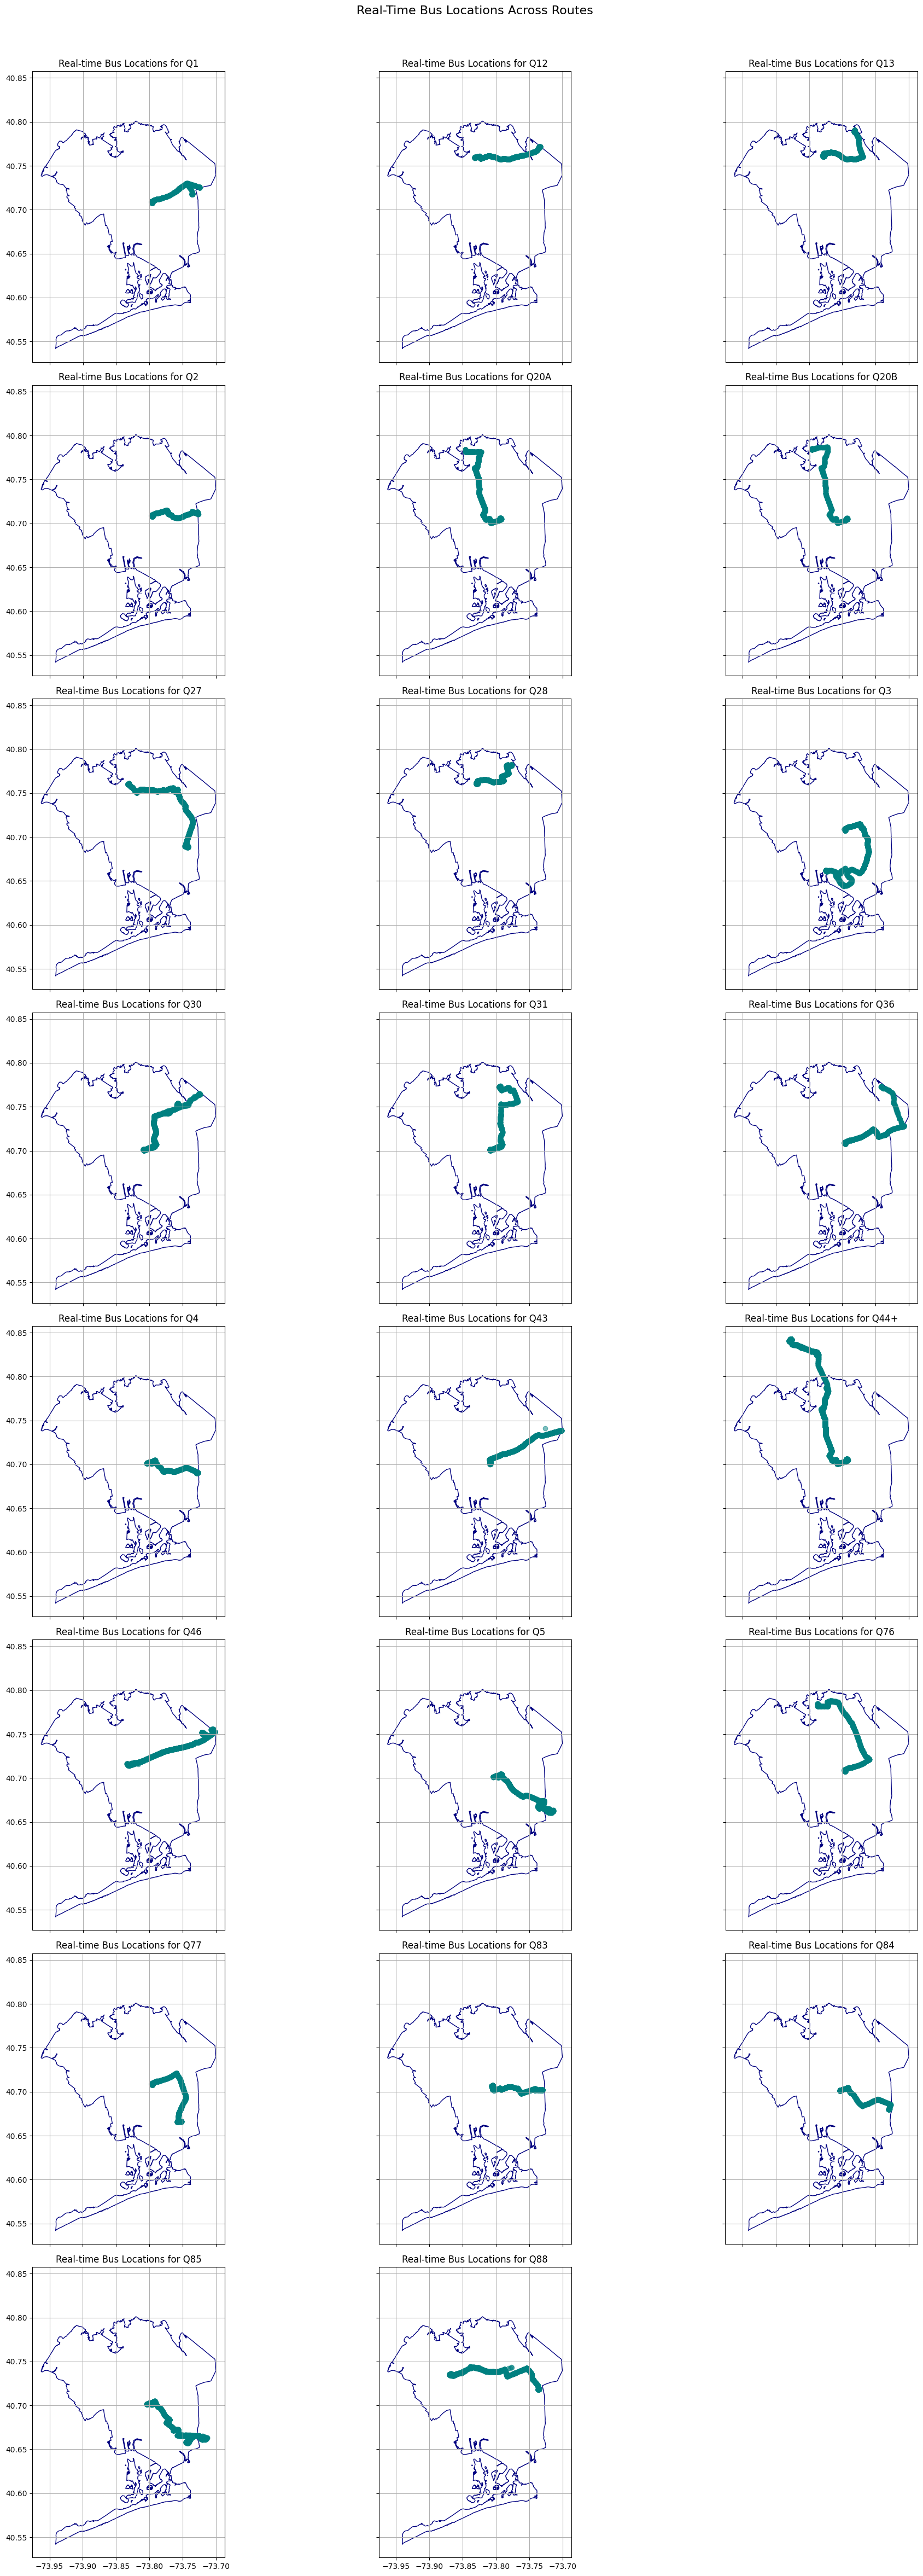

In [85]:
# Spatial Analysis
# Number of routes and subplots per row
n_routes = len(real_time_dfs)
n_cols = 3  # Number of subplots per row
n_rows = int(np.ceil(n_routes / n_cols))  # Calculate the number of rows needed

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows), sharex=True, sharey=True)

# Flatten axes for easier indexing
axes = axes.flatten()

# Loop through each route and plot its real-time locations
for idx, (route_id, df) in enumerate(real_time_dfs.items()):
    # Add a geometry column for GeoDataFrame
    df['geometry'] = df.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
    
    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

    # Plot the Queens boundaries as the base layer
    queens_boundaries.plot(ax = axes[idx], color = 'white', edgecolor = 'navy')
    
    # Plot on the corresponding subplo
    gdf.plot(ax=axes[idx], marker='o', color='teal', alpha=0.5)
    axes[idx].set_title(f'Real-time Bus Locations for {route_id}')
    axes[idx].grid(True)

# Hide any unused subplots
for i in range(len(real_time_dfs), len(axes)):
    fig.delaxes(axes[i])

# Set overall figure layout
fig.suptitle('Real-Time Bus Locations Across Routes', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.97])

plt.savefig('realtime_bus_locations_across_routes.png', dpi = 300)

# Show the plots
plt.show()

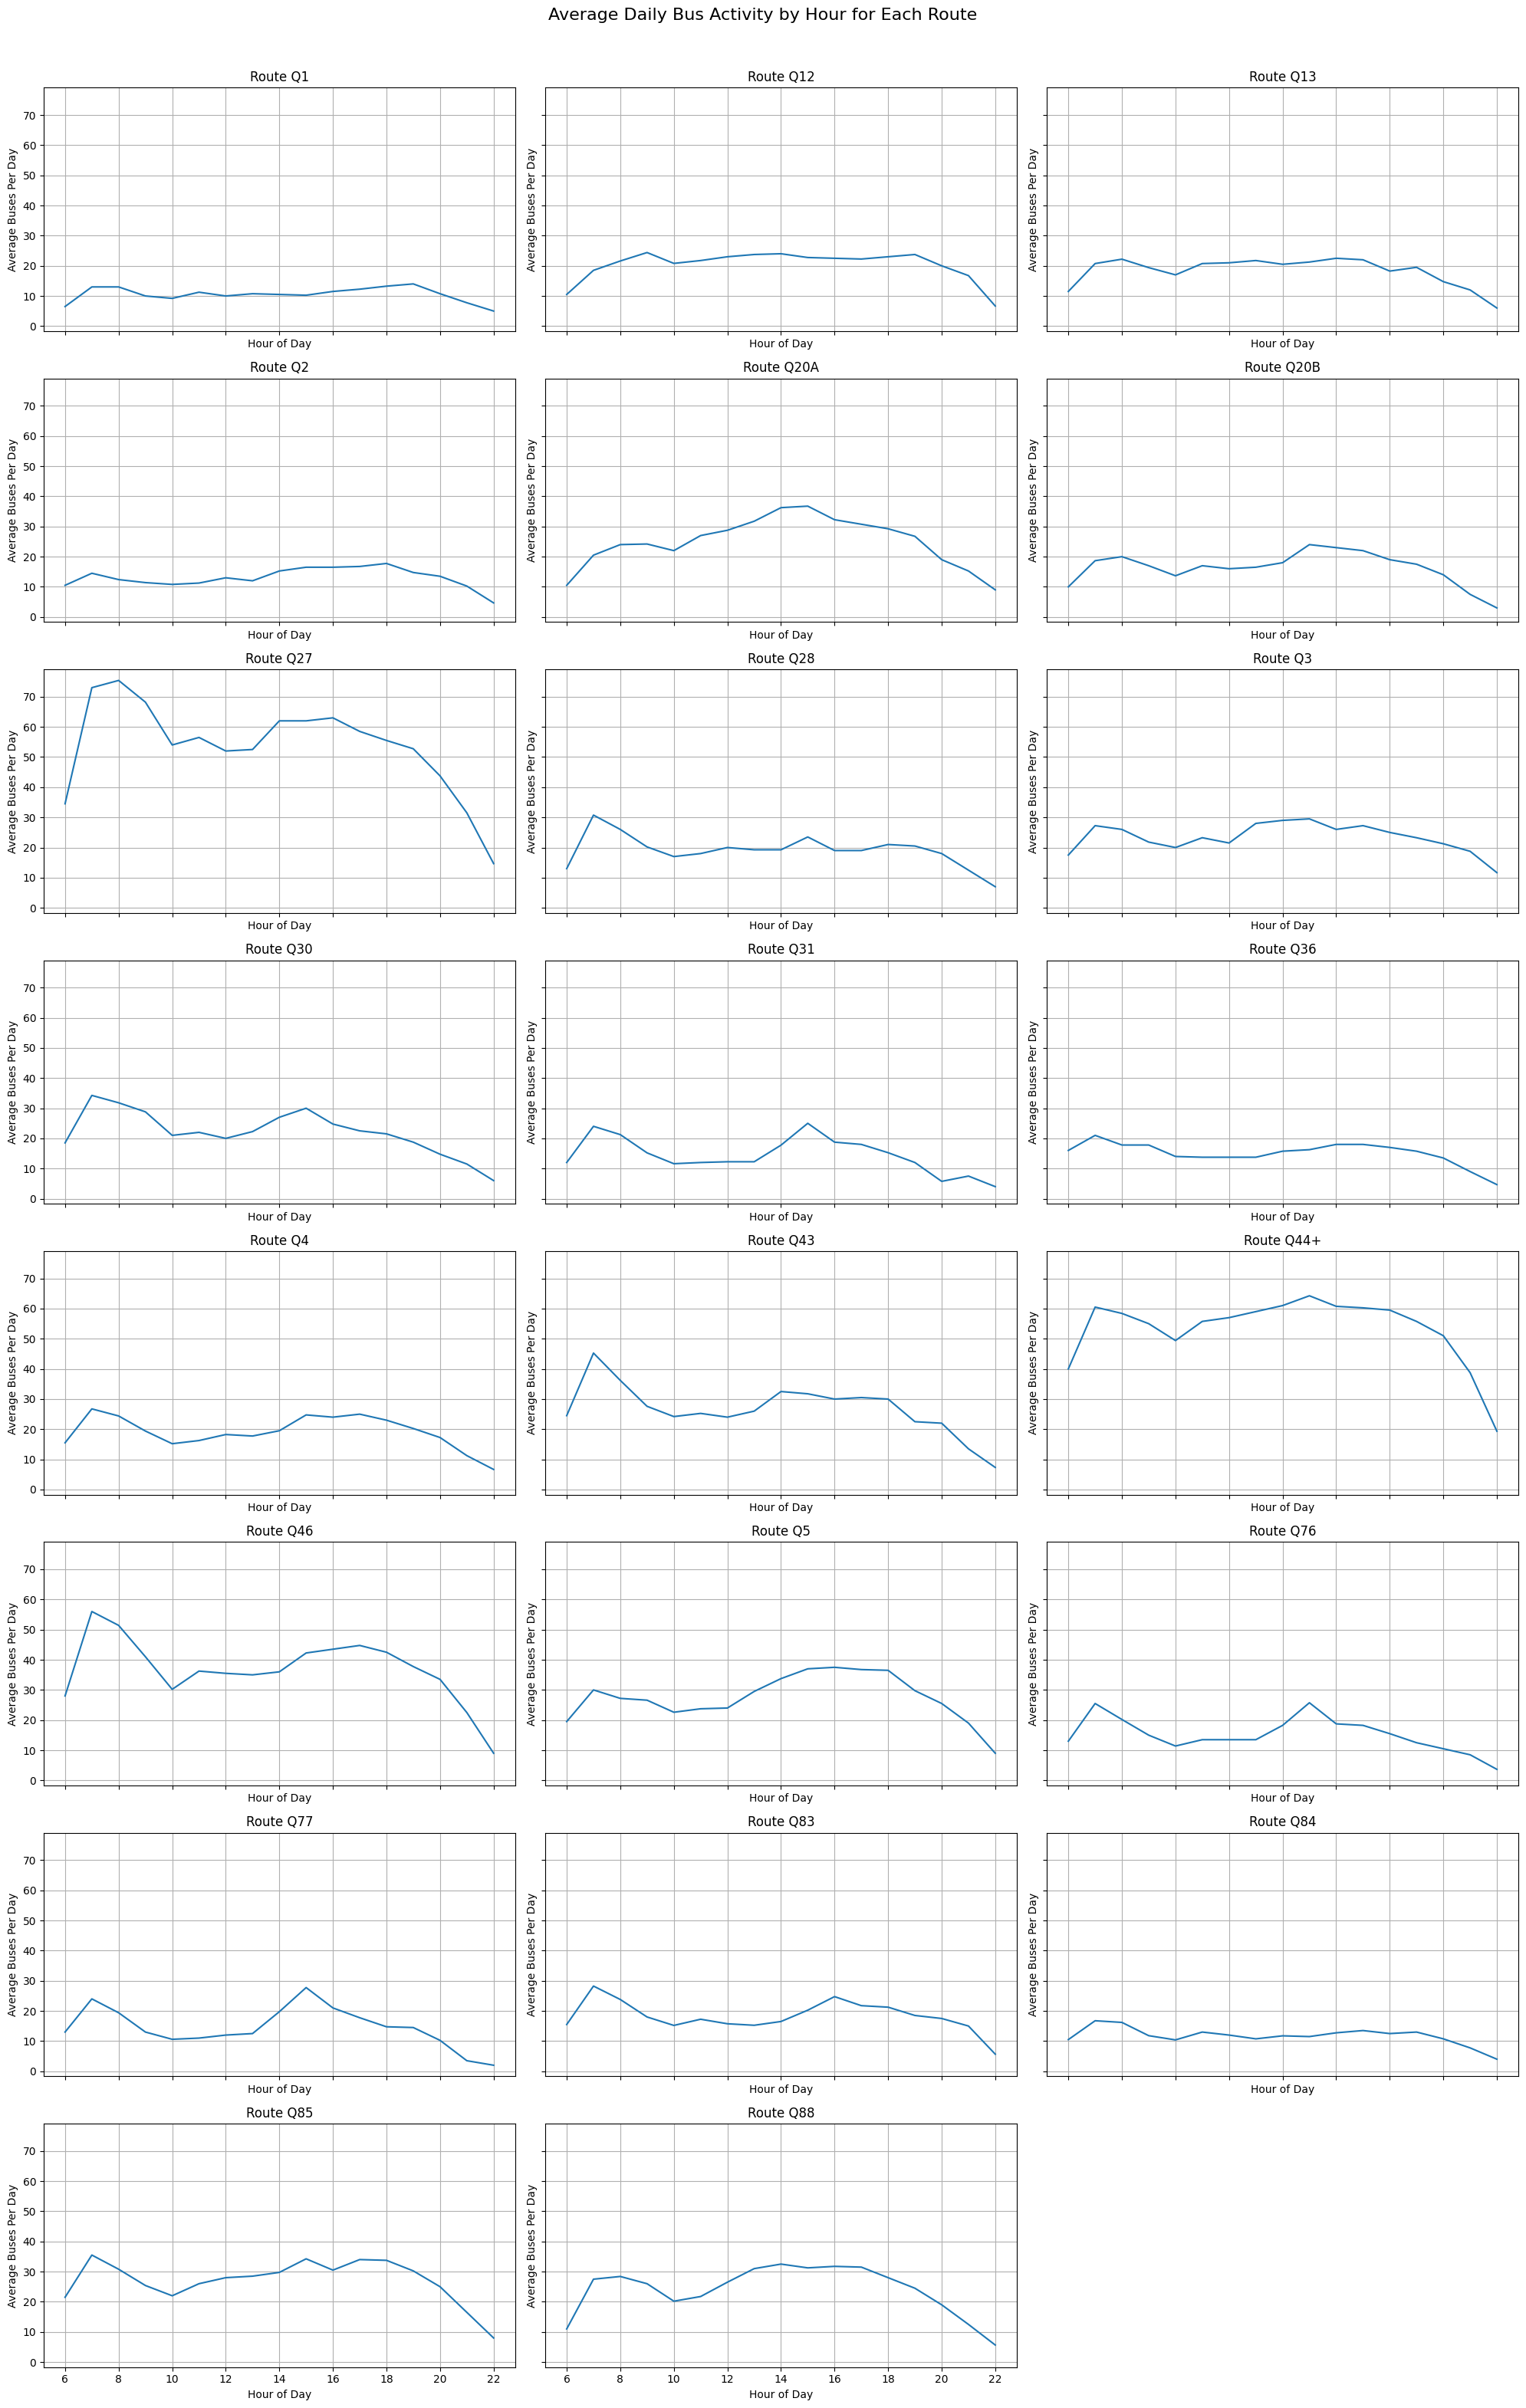

In [86]:
# Temporal Analysis
# Number of routes and subplots per row
n_routes = len(real_time_dfs)
n_cols = 3  # Number of subplots per row
n_rows = int(np.ceil(n_routes / n_cols))  # Calculate number of rows needed

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), sharex=True, sharey=True)

# Flatten axes for easier indexing
axes = axes.flatten()

# Loop through each route and plot its average daily activity by hour
for idx, (route_id, df) in enumerate(real_time_dfs.items()):
    # Extract the hour and date from the timestamp
    df['Hour'] = df['Timestamp'].dt.hour
    df['Date'] = df['Timestamp'].dt.date
    
    # Group by hour and date to get daily bus counts for each hour
    daily_hourly_activity = df.groupby(['Date', 'Hour']).size().reset_index(name='Daily Bus Count')
    
    # Group by hour to calculate the average bus count per day for each hour
    hourly_average_activity = daily_hourly_activity.groupby('Hour')['Daily Bus Count'].mean().reset_index(name='Average Buses')
    
    # Plot the data in the corresponding subplot
    ax = axes[idx]
    ax.plot(hourly_average_activity['Hour'], hourly_average_activity['Average Buses'])
    
    # Add title, labels, and grid to each subplot
    ax.set_title(f'Route {route_id}')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Average Buses Per Day')
    ax.grid(True)

# Hide any unused subplots
for i in range(len(real_time_dfs), len(axes)):
    fig.delaxes(axes[i])

# Set overall figure title and layout
fig.suptitle('Average Daily Bus Activity by Hour for Each Route', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.97])

plt.savefig('average_daily_bus_activity_by_hour_by_route.png', dpi = 300)

# Display the plot
plt.show()

In [82]:
# Identify outliers for each route
for route_id, df in real_time_dfs.items():
    low_activity_hours = df.groupby('Hour').size().reset_index(name = 'Bus Count')
    low_activity_hours = low_activity_hours[low_activity_hours['Bus Count'] < 20]
    display(f'Low activity hours for Route {route_id}:', low_activity_hours)

'Low activity hours for Route Q1:'

,Hour,Bus Count
0,6,13
16,22,15


'Low activity hours for Route Q12:'

,Hour,Bus Count


'Low activity hours for Route Q13:'

,Hour,Bus Count
16,22,18


'Low activity hours for Route Q2:'

,Hour,Bus Count
16,22,14


'Low activity hours for Route Q20A:'

,Hour,Bus Count


'Low activity hours for Route Q20B:'

,Hour,Bus Count
15,21,15
16,22,3


'Low activity hours for Route Q27:'

,Hour,Bus Count


'Low activity hours for Route Q28:'

,Hour,Bus Count


'Low activity hours for Route Q3:'

,Hour,Bus Count


'Low activity hours for Route Q30:'

,Hour,Bus Count
16,22,18


'Low activity hours for Route Q31:'

,Hour,Bus Count
15,21,15
16,22,4


'Low activity hours for Route Q36:'

,Hour,Bus Count
16,22,14


'Low activity hours for Route Q4:'

,Hour,Bus Count


'Low activity hours for Route Q43:'

,Hour,Bus Count


'Low activity hours for Route Q44+:'

,Hour,Bus Count


'Low activity hours for Route Q46:'

,Hour,Bus Count


'Low activity hours for Route Q5:'

,Hour,Bus Count


'Low activity hours for Route Q76:'

,Hour,Bus Count
16,22,11


'Low activity hours for Route Q77:'

,Hour,Bus Count
15,21,14
16,22,2


'Low activity hours for Route Q83:'

,Hour,Bus Count
16,22,17


'Low activity hours for Route Q84:'

,Hour,Bus Count
16,22,12


'Low activity hours for Route Q85:'

,Hour,Bus Count


'Low activity hours for Route Q88:'

,Hour,Bus Count
16,22,17


In [47]:
# Overlay Real-Time Activity for All Routes
# Combine real-time data for all routes
combined_realtime_gdf = gpd.GeoDataFrame(
    pd.concat(geo_dfs.values(), ignore_index = True),
    crs = 'EPSG:4326'
)

# Spatial join: Aggregate bus activity by neighborhood
bus_activity = gpd.sjoin(
    combined_realtime_gdf,
    eastern_queens_neighborhoods,
    how = 'inner',
    predicate = 'within'
)
bus_activity_counts = bus_activity.groupby('ntaname').size().reset_index(name = 'Bus Activity Count')

# Spatial join: Aggregate stop density by neighborhood
stop_density = gpd.sjoin(
    stops_gdf,
    eastern_queens_neighborhoods,
    how = 'inner',
    predicate = 'within'
)
stop_density_counts = stop_density.groupby('ntaname').size().reset_index(name = 'Stop Count')

# Merge bus activity and stop density into queens_neighborhoods
eastern_queens_neighborhoods = eastern_queens_neighborhoods.merge(
    bus_activity_counts,
    on = 'ntaname',
    how = 'left'
)
eastern_queens_neighborhoods = eastern_queens_neighborhoods.merge(
    stop_density_counts,
    on = 'ntaname',
    how = 'left'
)
eastern_queens_neighborhoods = eastern_queens_neighborhoods.fillna(0)

# Calculate Activity-to-Stop Ratio
eastern_queens_neighborhoods['Activity-to-Stop Ratio'] = (
    eastern_queens_neighborhoods['Bus Activity Count'] / eastern_queens_neighborhoods['Stop Count']
)
eastern_queens_neighborhoods['Activity-to-Stop Ratio'] = eastern_queens_neighborhoods['Activity-to-Stop Ratio'].fillna(0)

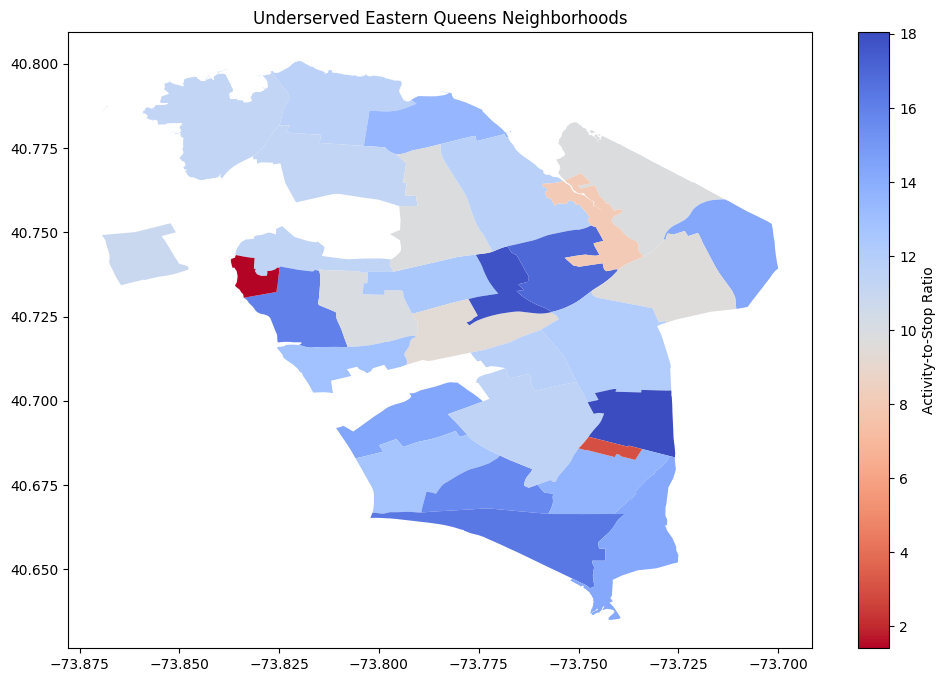

In [48]:
# Identify underseved neighborhoods
underserved = eastern_queens_neighborhoods[eastern_queens_neighborhoods['Activity-to-Stop Ratio'] < 20]

# Visualize underserved neighborhoods
underserved.plot(
    column = 'Activity-to-Stop Ratio',
    cmap = 'coolwarm_r',
    legend = True,
    figsize = (12, 8),
    legend_kwds = {'label': 'Activity-to-Stop Ratio'}
)
plt.gca().set_aspect("auto")
plt.title('Underserved Eastern Queens Neighborhoods')
plt.show()

In [49]:
# Summarize underserved neighborhoods
underserved_summary = underserved[['ntaname', 'Bus Activity Count', 'Stop Count', 'Activity-to-Stop Ratio']]

# Save as CSV
underserved_summary.to_csv('../data/underserved_neighborhoods_combined.csv')